In [1]:
import deepxde as dde
import numpy as np

Using backend: pytorch



In [2]:
# --Full viscosity and diffusivity--
v_z = 1.0
v_h = 1.0
k_z = 1.0
k_h = 1.0
Q = lambda t, x, z: 0.0

Set the default float type to float64
Compiling model...
'compile' took 0.000072 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [9.18e-03, 8.16e-02, 6.24e-02, 8.44e-02, 2.73e-01, 8.53e-04, 2.74e-02, 2.89e-04, 5.28e-03, 3.10e-03, 4.72e-03, 1.47e-04, 9.83e-02, 1.54e-01, 1.71e-03, 2.90e-02]    [9.18e-03, 8.16e-02, 6.24e-02, 8.44e-02, 2.73e-01, 8.53e-04, 2.74e-02, 2.89e-04, 5.28e-03, 3.10e-03, 4.72e-03, 1.47e-04, 9.83e-02, 1.54e-01, 1.71e-03, 2.90e-02]    []  
100       [5.45e-05, 3.74e-06, 2.19e-05, 1.75e-05, 2.25e-01, 1.34e-06, 1.13e-05, 4.17e-03, 6.64e-03, 5.06e-06, 1.75e-06, 2.29e-06, 8.89e-07, 1.05e-05, 2.50e-06, 2.84e-06]    [5.45e-05, 3.74e-06, 2.19e-05,

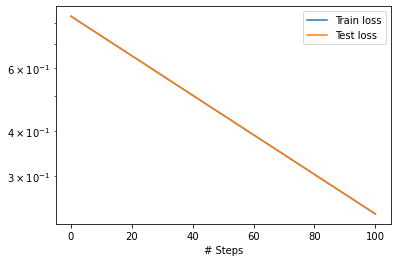

In [3]:
# --Setup space and time domains--
x_min, x_max = 0, 1
z_min, z_max = 0, 1
t_min, t_max = 0, 1
space_domain = dde.geometry.Rectangle([x_min, z_min], [x_max, z_max])
time_domain = dde.geometry.TimeDomain(t_min, t_max)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# --Reference solution--
def solution(xzt):
    x = xzt[:, 0:1]
    z = xzt[:, 1:2]
    t = xzt[:, 2:3]
    
    u = -np.sin(np.pi*x) * np.cos(np.pi*z) * np.exp(-np.pi*np.pi*(v_h + v_z)*t)
    w = np.cos(np.pi*x) * np.sin(np.pi*z) * np.exp(-np.pi*np.pi*(v_h + v_z)*t)
    p = np.cos(2*np.pi*x) * np.exp(-2*np.pi*np.pi*(v_h + v_z)*t) / 4.0
    T = 0
    
    return np.hstack((u, w, p, T))

# --PDE interior residuals--
def primitive_equations(x, y):
    u = y[:, 0:1]
    w = y[:, 1:2]
    p = y[:, 2:3]
    T = y[:, 3:4]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_z = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dw_z = dde.grad.jacobian(y, x, i=1, j=1)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_z = dde.grad.jacobian(y, x, i=2, j=1)
    dT_x = dde.grad.jacobian(y, x, i=3, j=0)
    dT_z = dde.grad.jacobian(y, x, i=3, j=1)
    dT_t = dde.grad.jacobian(y, x, i=3, j=2)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_zz = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dT_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)
    dT_zz = dde.grad.hessian(y, x, component=3, i=1, j=1)
    
    # PDE residuals
    pde1 = du_t + u*du_x + w*du_z - v_h*du_xx - v_z*du_zz + dp_x
    pde2 = dp_z + T
    pde3 = du_x + dw_z
    pde4 = dT_t + u*dT_x + w*dT_z - k_h*dT_xx - k_z*dT_zz
    
    return [pde1, pde2, pde3, pde4]

# --Initial conditions--
def init_cond_u(x):
    return np.sin(np.pi*x[:, 0:1]) * np.cos(np.pi*x[:, 1:2])
def init_cond_T(x):
    return 0.0
ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_T = dde.icbc.IC(geomtime, init_cond_T, lambda _, on_initial: on_initial, component=3)
ics = [ic_u, ic_T]

# --Boundary conditions for each function--
def z_boundary(x, on_boundary):
    return on_boundary and (np.isclose(x[1], 0) or np.isclose(x[1], 1))

# this line is necessaryNumpy arrays default to float64
dde.config.set_default_float('float64')

ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_T = dde.icbc.IC(geomtime, init_cond_T, lambda _, on_initial: on_initial, component=3)
ics = [ic_u, ic_T]
bc_u_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_u_z = dde.icbc.PeriodicBC(geomtime, 1, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_du_z = dde.icbc.NeumannBC(geomtime, lambda x: 0, z_boundary, component=0)

bc_w_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1)
bc_w_z = dde.icbc.DirichletBC(geomtime, lambda x: 0, z_boundary, component=1)

bc_p_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2)
bc_p_z = dde.icbc.PeriodicBC(geomtime, 1, lambda _, on_boundary: on_boundary, derivative_order=0, component=2)
bc_dp_z = dde.icbc.NeumannBC(geomtime, lambda x: 0, z_boundary, component=2)

bc_T_x = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3)
bc_T_z = dde.icbc.DirichletBC(geomtime, lambda x: 0, z_boundary, component=3)

bcs = [bc_u_x, bc_u_z, bc_du_z, bc_w_x, bc_w_z, bc_p_x, bc_p_z, bc_dp_z, bc_T_x, bc_T_z]

data = dde.data.TimePDE(
    geomtime,
    primitive_equations,
    [*ics, *bcs],
    num_domain=5000,
    num_boundary=500,
    num_initial=500,
    train_distribution='uniform',
    # solution=solution
)

# --Network architecture--
layer_size = [3] + [128] * 2 + [4]
activation = 'tanh'
initializer = 'Glorot normal'
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile('adam', lr=8e-4, loss='MSE')
loss_history, train_state = model.train(epochs=100)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)